## Day 4: Support Vector Machines

In this assignment, you'll write code for and experiment with support vector machines (this is still _supervised_ learning, so our data are labeled).  

In [25]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from utils import *

import numpy as np
import cvxopt
import matplotlib as mpl
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt

The optimization problem that we're trying to solve with an SVM is 
$$
\min \frac{1}{n} \sum_{i = 1}^{n} \zeta_i + \lambda \|w\|^2 \\
\text{subject to: } y_i(w \cdot x_i) - b \geq 1 - \zeta_i \\
 \zeta_i \geq 0
$$

The code below will define the class SVM. Find the matrices P, q, G, and h, and fill in code in the "compute_multipliers" function to compute the minimization. Rememeber that they have to be __cvxopt.matrix__ variables. Additionally, write the code to compute the kernel matrix K in __kernel_matrix__.

In [26]:
class SVM(object):
    def __init__(self, kernel, c):
        """
        Build a SVM given kernel function and C

        Parameters
        ----------
        kernel : function
            a function takes input (Matrix, vector) or (vector, vector)
        c : a scalar
            balance term

        Returns
        -------
        """
        self._kernel = kernel
        self._c = c

    def fit(self, X, y):
        """
        Fit the model given data X and ground truth label y

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label                    

        Returns
        -------
        """
        #Expand X by adding a column of 1 to capture bias
        X=np.column_stack((X,np.ones((X.shape[0],1))))
        
        # Solve the QP problem to get the multipliers
        beta = self._compute_multipliers(X, y)
        # Get all the support vectors, support weights and bias
        self._construct_predictor(X, y, beta)        
    
    def predict(self, X):
        """
        Predict the label given data X

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        y : 1D array
            predicted label

        """
        
        N, d = X.shape
        #Expand X by adding a column of 1 to capture bias
        X=np.column_stack((X,np.ones((N,1))))
        
        result = np.zeros(X.shape[0])
        for z_i, x_i, in zip(self._weights,
                                 self._support_vectors):
            result += z_i * self._kernel(X, x_i)
        return np.sign(result)
    
    def decision_function(self, X):
        """
        Predict the decision_function value f(x)=w.x given data X

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        y : 1D array
            predicted f(x)
        """
        
        N, d = X.shape
        #Expand X by adding a column of 1 to capture bias
        X=np.column_stack((X,np.ones((N,1))))
        
        result = np.zeros(X.shape[0])
        for z_i, x_i, in zip(self._weights,
                                 self._support_vectors):
            result += z_i * self._kernel(X, x_i)
        return result

    def _kernel_matrix(self, X):
        """
        Get the kernel matrix.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        K : 2D array
            N x N kernel matrix
     
        ----------------------
        self._kernel(X, x_i) is an 1-D array of length N (the number of samples in X)
        the j-th element of which is the dot product of x_i and x_j, i.e., the whole array is:
        [x_1 * x_i, x_2 * x_i, ..., x_j * x_i, ..., x_N * x_i]
        """
        N, d = X.shape
        K = np.zeros((N, N))
        
        for i in range(N):
            K[i] = self._kernel(X, X[i])
        
        return K

    def _construct_predictor(self, X, y, beta):
        """
        Given the data, label and the multipliers, extract the support vectors and calculate the bias

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label
        beta: 1D array
            the solution of betas

        Returns
        -------
        """
        support_vector_indices = \
            np.abs(beta) > 1e-5
            
        #print("SV number: ", np.sum(support_vector_indices))

        support_multipliers = beta[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]

        
        self._weights=support_multipliers
        self._support_vectors=support_vectors
        self._support_vector_labels=support_vector_labels

        
    def _compute_multipliers(self, X, y):
        """
        Given the data, label, solve the QP program to get betas.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example with added column of 1s)
        y : 1D array
            class label

        Returns
        beta: 1D array
        -------
        """
        N, d = X.shape                        
        K = self._kernel_matrix(X)
      
        """
        The standard QP solver formulation:
        min 1/2 x^T P x + q^T x
        s.t.
        Gx <= h
        Ax = b
        
        The in this case (in the notation from the slides), we are trying to solve:
        min b^T G b
        s.t.
        -y_i (G b)_i <= -1 for all i
        
        Write out the code to optimize this. Refer back to the slides.
        """
        
        # quadratic coefficient
        P = cvxopt.matrix(np.multiply(np.outer(y, y), K))
        
        # q (linear coefficient)
        q = cvxopt.matrix(-1 * np.ones(N))
        
        # gram matrix
        G_std = cvxopt.matrix(np.diag(np.ones(N) * -1))
        G_slack = cvxopt.matrix(np.diag(np.ones(N) * self._c))
        G = cvxopt.matrix(np.vstack((G_std, G_slack)))
        
        h_std = cvxopt.matrix(np.zeros(N))
        h_slack = cvxopt.matrix(np.ones(N) * self._c)
        h = cvxopt.matrix(np.vstack((h_std, h_slack)))
        
        A = cvxopt.matrix(y.reshape(1, N))
        
        b = cvxopt.matrix(0.0)
        
        solution = cvxopt.solvers.qp(P=P, q=q, G=G, h=h, A=A, b=b, kktsolver='ldl', options={'kktreg':1e-9})
        
        # Lagrange multipliers
        return np.ravel(solution['x'])

Below is code that defines the class of Kernel objects. 

In [27]:
class Kernel(object):
    """
    A class containing all kinds of kernels.
    Note: the kernel should work for both input (Matrix, vector) 
    and (vector, vector)
    """
    @staticmethod
    def linear():
        def f(x, y):
            return np.dot(x, y)
        return f

    @staticmethod
    def gaussian(gamma):
        def f(x, y):
            exponent = - gamma * np.linalg.norm((x-y).transpose(), 2, 0) ** 2
            return np.exp(exponent)
        return f

    @staticmethod
    def _poly(dimension, offset):
        def f(x, y):
            return (offset + np.dot(x, y)) ** dimension
        return f

    @staticmethod
    def inhomogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=1.0)

    @staticmethod
    def homogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=0.0)

    @staticmethod
    def hyperbolic_tangent(kappa, c):
        def f(x, y):
            return np.tanh(kappa * np.dot(x, y) + c)
        return f

Test your code with the example below. 

x (100, 2) y (100,)


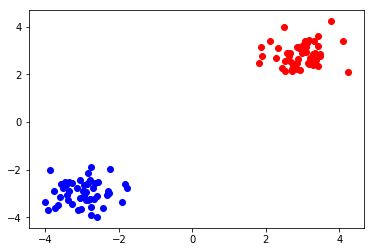

In [28]:
dim = 2
colors = ['red','blue']
# 2-D mean of ones
M1 = -3*np.ones((dim,))
# 2-D mean of threes
M2 = 3* np.ones((dim,))
# 2-D covariance of 0.3
C1 = np.diag(0.3 * np.ones((dim,)))
# 2-D covariance of 0.2
C2 = np.diag(0.2 * np.ones((dim,)))

def generate_gaussian(m, c, num):
    return np.random.multivariate_normal(m, c, num)

def plot_data_with_labels(x, y):
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        plt.scatter(x_sub[:, 0], x_sub[:, 1], c = colors[li])
    plt.show()
    
num = 50
x1 = generate_gaussian(M1, C1, num)
y1 = np.ones((x1.shape[0],))
x2 = generate_gaussian(M2, C2, num)
y2 = -np.ones((x2.shape[0],))
x = np.concatenate((x1, x2), axis = 0)
y = np.concatenate((y1, y2), axis = 0)
print('x {} y {}'.format(x.shape, y.shape))
plot_data_with_labels(x, y)


In [29]:
clf = SVM(Kernel.linear(),1)
clf.fit(x,y)
#Check margin constraints are satisfies
fx=clf.decision_function(x)
print("minimum margin:", np.min(y*fx))

     pcost       dcost       gap    pres   dres
 0: -1.5973e+00 -1.3823e+02  6e+02  2e+00  1e-10
 1: -6.1843e-01 -5.4685e+01  8e+01  1e-01  6e-11
 2:  8.0195e-02 -3.7362e+00  5e+00  8e-03  5e-11
 3:  2.8407e-02 -2.2323e-01  3e-01  8e-05  4e-12
 4: -3.2311e-02 -6.0611e-02  3e-02  1e-09  7e-13
 5: -4.4868e-02 -6.4761e-02  2e-02  3e-09  4e-12
 6: -5.4301e-02 -5.7997e-02  4e-03  4e-10  3e-12
 7: -5.5794e-02 -5.5834e-02  4e-05  1e-09  4e-13
 8: -5.5810e-02 -5.5811e-02  4e-07  1e-09  9e-15
 9: -5.5811e-02 -5.5811e-02  4e-09  1e-09  3e-16
Optimal solution found.
minimum margin: -0.165836819882765


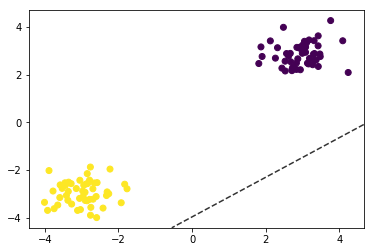

In [30]:
#plot decision boundary
plt.scatter(x[:,0],x[:,1],c = y)
# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
# find the function evaluation at each grid point
Z = (clf.decision_function(xy)).reshape(XX.shape)


# plot decision boundary and margins
# regions where f(x)=0, f(x)=+1,f(x)=-1)
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8,linestyles=['--', '-', '--'])

plt.show()